<a href="https://colab.research.google.com/github/ishwarraja/SOAI-ERAV2/blob/main/S9/DPDIAOPT/modular/S9_DPDIAOPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [4]:
class Cifar10SearchDataset(datasets.CIFAR10):
    def __init__(self, root="~/data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, label

In [5]:
train = Cifar10SearchDataset(root='./data', train=True,download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 94242162.15it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


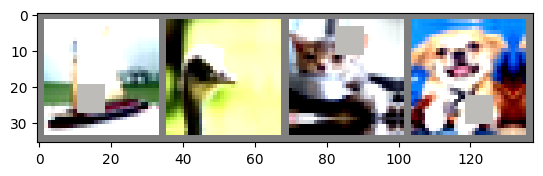

ship  bird  cat   dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3/1


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, groups=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5/1

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=64,
                kernel_size=(3,3),
                padding=2,
                stride=2,
                dilation=2,
                bias=False),
        ) # output_size = 16/7/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, groups=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 16/11/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=128, groups=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 16/15/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=64,
                      kernel_size=(3,3),
                      padding=2,
                      dilation=2,
                      stride=2,
                      bias=False),
        ) # output_size = 8/19/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, groups=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, groups = 64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, groups=64,  out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 6/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1/64

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             288
            Conv2d-6          [-1, 128, 32, 32]           4,096
              ReLU-7          [-1, 128, 32, 32]               0
       BatchNorm2d-8          [-1, 128, 32, 32]             256
           Dropout-9          [-1, 128, 32, 32]               0
           Conv2d-10           [-1, 64, 16, 16]          73,728
           Conv2d-11           [-1, 64, 16, 16]             576
           Conv2d-12          [-1, 128, 16, 16]           8,192
             ReLU-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1,

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.5794165134429932 Batch_id=97 Accuracy=30.72: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]



Test set: Average loss: 1.5681, Accuracy: 4167/10000 (41.67%)

EPOCH: 1


Loss=1.4278862476348877 Batch_id=97 Accuracy=44.01: 100%|██████████| 98/98 [00:17<00:00,  5.56it/s]



Test set: Average loss: 1.4495, Accuracy: 4593/10000 (45.93%)

EPOCH: 2


Loss=1.3491071462631226 Batch_id=97 Accuracy=50.19: 100%|██████████| 98/98 [00:17<00:00,  5.45it/s]



Test set: Average loss: 1.3492, Accuracy: 5134/10000 (51.34%)

EPOCH: 3


Loss=1.1720377206802368 Batch_id=97 Accuracy=54.82: 100%|██████████| 98/98 [00:17<00:00,  5.47it/s]



Test set: Average loss: 1.1539, Accuracy: 5785/10000 (57.85%)

EPOCH: 4


Loss=1.057662844657898 Batch_id=97 Accuracy=58.80: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set: Average loss: 1.0087, Accuracy: 6393/10000 (63.93%)

EPOCH: 5


Loss=0.9994456768035889 Batch_id=97 Accuracy=61.68: 100%|██████████| 98/98 [00:17<00:00,  5.48it/s]



Test set: Average loss: 0.9906, Accuracy: 6462/10000 (64.62%)

EPOCH: 6


Loss=1.03164541721344 Batch_id=97 Accuracy=64.30: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]



Test set: Average loss: 0.8949, Accuracy: 6811/10000 (68.11%)

EPOCH: 7


Loss=1.0508571863174438 Batch_id=97 Accuracy=66.21: 100%|██████████| 98/98 [00:17<00:00,  5.48it/s]



Test set: Average loss: 0.8534, Accuracy: 6925/10000 (69.25%)

EPOCH: 8


Loss=0.843486487865448 Batch_id=97 Accuracy=67.50: 100%|██████████| 98/98 [00:18<00:00,  5.37it/s]



Test set: Average loss: 0.8195, Accuracy: 7088/10000 (70.88%)

EPOCH: 9


Loss=0.8604710102081299 Batch_id=97 Accuracy=68.83: 100%|██████████| 98/98 [00:17<00:00,  5.47it/s]



Test set: Average loss: 0.7549, Accuracy: 7330/10000 (73.30%)

EPOCH: 10


Loss=0.7684395909309387 Batch_id=97 Accuracy=70.07: 100%|██████████| 98/98 [00:18<00:00,  5.30it/s]



Test set: Average loss: 0.7949, Accuracy: 7197/10000 (71.97%)

EPOCH: 11


Loss=0.7615073919296265 Batch_id=97 Accuracy=71.21: 100%|██████████| 98/98 [00:18<00:00,  5.39it/s]



Test set: Average loss: 0.7348, Accuracy: 7419/10000 (74.19%)

EPOCH: 12


Loss=0.8210636377334595 Batch_id=97 Accuracy=72.30: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]



Test set: Average loss: 0.6924, Accuracy: 7570/10000 (75.70%)

EPOCH: 13


Loss=0.7524820566177368 Batch_id=97 Accuracy=73.20: 100%|██████████| 98/98 [00:18<00:00,  5.38it/s]



Test set: Average loss: 0.6906, Accuracy: 7627/10000 (76.27%)

EPOCH: 14


Loss=0.7181878685951233 Batch_id=97 Accuracy=74.23: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]



Test set: Average loss: 0.6987, Accuracy: 7564/10000 (75.64%)

EPOCH: 15


Loss=0.7143007516860962 Batch_id=97 Accuracy=74.33: 100%|██████████| 98/98 [00:18<00:00,  5.32it/s]



Test set: Average loss: 0.6287, Accuracy: 7831/10000 (78.31%)

EPOCH: 16


Loss=0.7005617618560791 Batch_id=97 Accuracy=75.38: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]



Test set: Average loss: 0.6106, Accuracy: 7909/10000 (79.09%)

EPOCH: 17


Loss=0.6442224383354187 Batch_id=97 Accuracy=75.93: 100%|██████████| 98/98 [00:18<00:00,  5.31it/s]



Test set: Average loss: 0.5977, Accuracy: 7929/10000 (79.29%)

EPOCH: 18


Loss=0.7084139585494995 Batch_id=97 Accuracy=76.30: 100%|██████████| 98/98 [00:18<00:00,  5.42it/s]



Test set: Average loss: 0.6005, Accuracy: 7946/10000 (79.46%)

EPOCH: 19


Loss=0.6204692721366882 Batch_id=97 Accuracy=76.77: 100%|██████████| 98/98 [00:18<00:00,  5.28it/s]



Test set: Average loss: 0.5901, Accuracy: 7958/10000 (79.58%)

EPOCH: 20


Loss=0.6408502459526062 Batch_id=97 Accuracy=77.43: 100%|██████████| 98/98 [00:18<00:00,  5.43it/s]



Test set: Average loss: 0.5959, Accuracy: 7933/10000 (79.33%)

EPOCH: 21


Loss=0.5857769846916199 Batch_id=97 Accuracy=77.79: 100%|██████████| 98/98 [00:18<00:00,  5.28it/s]



Test set: Average loss: 0.5561, Accuracy: 8085/10000 (80.85%)

EPOCH: 22


Loss=0.7109420299530029 Batch_id=97 Accuracy=77.77: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]



Test set: Average loss: 0.5522, Accuracy: 8107/10000 (81.07%)

EPOCH: 23


Loss=0.5666979551315308 Batch_id=97 Accuracy=78.35: 100%|██████████| 98/98 [00:18<00:00,  5.29it/s]



Test set: Average loss: 0.5546, Accuracy: 8106/10000 (81.06%)

EPOCH: 24


Loss=0.6770225763320923 Batch_id=97 Accuracy=78.73: 100%|██████████| 98/98 [00:17<00:00,  5.45it/s]



Test set: Average loss: 0.5356, Accuracy: 8172/10000 (81.72%)

EPOCH: 25


Loss=0.6671141386032104 Batch_id=97 Accuracy=79.13: 100%|██████████| 98/98 [00:18<00:00,  5.37it/s]



Test set: Average loss: 0.5261, Accuracy: 8173/10000 (81.73%)

EPOCH: 26


Loss=0.6097105145454407 Batch_id=97 Accuracy=79.47: 100%|██████████| 98/98 [00:18<00:00,  5.36it/s]



Test set: Average loss: 0.5728, Accuracy: 8073/10000 (80.73%)

EPOCH: 27


Loss=0.5858332514762878 Batch_id=97 Accuracy=79.58: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]



Test set: Average loss: 0.5266, Accuracy: 8173/10000 (81.73%)

EPOCH: 28


Loss=0.5145465135574341 Batch_id=97 Accuracy=80.20: 100%|██████████| 98/98 [00:18<00:00,  5.36it/s]



Test set: Average loss: 0.5474, Accuracy: 8177/10000 (81.77%)

EPOCH: 29


Loss=0.4994620680809021 Batch_id=97 Accuracy=80.41: 100%|██████████| 98/98 [00:17<00:00,  5.46it/s]



Test set: Average loss: 0.5070, Accuracy: 8305/10000 (83.05%)

EPOCH: 30


Loss=0.5161512494087219 Batch_id=97 Accuracy=80.38: 100%|██████████| 98/98 [00:18<00:00,  5.32it/s]



Test set: Average loss: 0.4903, Accuracy: 8333/10000 (83.33%)

EPOCH: 31


Loss=0.5105549097061157 Batch_id=97 Accuracy=80.87: 100%|██████████| 98/98 [00:18<00:00,  5.40it/s]



Test set: Average loss: 0.5151, Accuracy: 8269/10000 (82.69%)

EPOCH: 32


Loss=0.5699481964111328 Batch_id=97 Accuracy=80.96: 100%|██████████| 98/98 [00:18<00:00,  5.31it/s]



Test set: Average loss: 0.4844, Accuracy: 8371/10000 (83.71%)

EPOCH: 33


Loss=0.6267361044883728 Batch_id=97 Accuracy=81.36: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s]



Test set: Average loss: 0.4936, Accuracy: 8306/10000 (83.06%)

EPOCH: 34


Loss=0.46433594822883606 Batch_id=97 Accuracy=81.66: 100%|██████████| 98/98 [00:18<00:00,  5.36it/s]



Test set: Average loss: 0.4723, Accuracy: 8389/10000 (83.89%)

EPOCH: 35


Loss=0.5144475698471069 Batch_id=97 Accuracy=81.88: 100%|██████████| 98/98 [00:17<00:00,  5.46it/s]



Test set: Average loss: 0.4782, Accuracy: 8396/10000 (83.96%)

EPOCH: 36


Loss=0.5022889971733093 Batch_id=97 Accuracy=82.16: 100%|██████████| 98/98 [00:18<00:00,  5.36it/s]



Test set: Average loss: 0.4660, Accuracy: 8429/10000 (84.29%)

EPOCH: 37


Loss=0.5015490651130676 Batch_id=97 Accuracy=81.94: 100%|██████████| 98/98 [00:17<00:00,  5.47it/s]



Test set: Average loss: 0.4824, Accuracy: 8382/10000 (83.82%)

EPOCH: 38


Loss=0.5154088735580444 Batch_id=97 Accuracy=82.20: 100%|██████████| 98/98 [00:18<00:00,  5.31it/s]



Test set: Average loss: 0.4745, Accuracy: 8381/10000 (83.81%)

EPOCH: 39


Loss=0.5087514519691467 Batch_id=97 Accuracy=82.70: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s]



Test set: Average loss: 0.4648, Accuracy: 8428/10000 (84.28%)

EPOCH: 40


Loss=0.5233606696128845 Batch_id=97 Accuracy=82.77: 100%|██████████| 98/98 [00:18<00:00,  5.37it/s]



Test set: Average loss: 0.4603, Accuracy: 8451/10000 (84.51%)

EPOCH: 41


Loss=0.4402051270008087 Batch_id=97 Accuracy=82.51: 100%|██████████| 98/98 [00:17<00:00,  5.46it/s]



Test set: Average loss: 0.4838, Accuracy: 8348/10000 (83.48%)

EPOCH: 42


Loss=0.5033116936683655 Batch_id=97 Accuracy=82.86: 100%|██████████| 98/98 [00:18<00:00,  5.40it/s]



Test set: Average loss: 0.4613, Accuracy: 8447/10000 (84.47%)

EPOCH: 43


Loss=0.4724283814430237 Batch_id=97 Accuracy=83.11: 100%|██████████| 98/98 [00:18<00:00,  5.39it/s]



Test set: Average loss: 0.4651, Accuracy: 8454/10000 (84.54%)

EPOCH: 44


Loss=0.4578206539154053 Batch_id=97 Accuracy=83.17: 100%|██████████| 98/98 [00:17<00:00,  5.48it/s]



Test set: Average loss: 0.4574, Accuracy: 8461/10000 (84.61%)

EPOCH: 45


Loss=0.45910072326660156 Batch_id=97 Accuracy=83.31: 100%|██████████| 98/98 [00:18<00:00,  5.32it/s]



Test set: Average loss: 0.4487, Accuracy: 8504/10000 (85.04%)

EPOCH: 46


Loss=0.5617167949676514 Batch_id=97 Accuracy=83.62: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s]



Test set: Average loss: 0.4396, Accuracy: 8522/10000 (85.22%)

EPOCH: 47


Loss=0.4558546841144562 Batch_id=97 Accuracy=83.69: 100%|██████████| 98/98 [00:18<00:00,  5.31it/s]



Test set: Average loss: 0.4463, Accuracy: 8511/10000 (85.11%)

EPOCH: 48


Loss=0.4337053894996643 Batch_id=97 Accuracy=83.78: 100%|██████████| 98/98 [00:17<00:00,  5.46it/s]



Test set: Average loss: 0.4432, Accuracy: 8533/10000 (85.33%)

EPOCH: 49


Loss=0.45375216007232666 Batch_id=97 Accuracy=83.91: 100%|██████████| 98/98 [00:18<00:00,  5.32it/s]



Test set: Average loss: 0.4284, Accuracy: 8560/10000 (85.60%)



In [12]:

# Count the Number of Receptive Field for the Model
# import torch
# import torch.nn as nn
# from model import Net

def get_receptive_field(model):
    receptive_field = 1
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            dilation = module.dilation[0]
            kernel_size = module.kernel_size[0]
            stride = module.stride[0]
            receptive_field = (receptive_field - 1) * stride + dilation * (kernel_size - 1) + 1
        elif isinstance(module, nn.MaxPool2d):
            kernel_size = module.kernel_size
            stride = module.stride
            receptive_field = (receptive_field - 1) * stride + kernel_size

    return receptive_field

# Create an instance of your model
model = Net()

# Calculate the receptive field
receptive_field_size = get_receptive_field(model)

# Check if the receptive field size is less than 44
if receptive_field_size < 44:
    print("The model has a receptive field size is less.",receptive_field_size)
else:
    print("The model has a receptive field size of 44 or more.")

The model has a receptive field size is less. 43


In [13]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): ReLU()
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2), bias=False)
  )
  (convblock4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): ReLU()
    (3): BatchNorm2d(128, eps=1e-05

In [14]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 16
conv_layers
